# Hybrid Model (CBF and CF)

## Import Relevant Libraries

Note: Use cuda (and T4 GPU for Google Colab) for the embedding process of Content-Based Filtering.

In [ ]:
import pandas as pd
import numpy as np
from google.colab import drive
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import gdown
from sklearn.metrics.pairwise import cosine_similarity
from scipy.sparse import csr_matrix
from sentence_transformers import SentenceTransformer
import torch
import pandas as pd
from sklearn.metrics import mean_squared_error
from scipy.special import softmax
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import ast

## Load preprocessed datasets into Colab

In [ ]:
#### MOVIES DATA #####
metadata_drive = '1vUxq_77g3r1jH1S3Zctmj-u5pArq7iZd'
gdown.download(f"https://drive.google.com/uc?id={metadata_drive}", "movies_metadata.csv", quiet=False)
df_movies_metadata = pd.read_csv("movies_metadata.csv")

##### LOAD RATINGS DATA ####
ratings_small_drive = '1lNJbFv82a2HTSaHqY7yloXoPovUpy6zn'
gdown.download(f"https://drive.google.com/uc?id={ratings_small_drive}", "ratings_small.csv", quiet=False)
df_ratings = pd.read_csv("ratings_small.csv")

Downloading...
From: https://drive.google.com/uc?id=1vUxq_77g3r1jH1S3Zctmj-u5pArq7iZd
To: /content/movies_metadata.csv
100%|██████████| 50.9M/50.9M [00:00<00:00, 67.9MB/s]
Downloading...
From: https://drive.google.com/uc?id=1lNJbFv82a2HTSaHqY7yloXoPovUpy6zn
To: /content/ratings_small.csv
100%|██████████| 1.46M/1.46M [00:00<00:00, 17.7MB/s]


In [ ]:
df_movies_metadata.head()

,adult,genres,id,original_language,original_title,overview,production_companies,production_countries,spoken_languages,release_year,runtime_category,vote_count_log,vote_average_norm,vote_count_norm,popularity_norm,years_since_release,keyword_values,textual_representation
0,False,"Animation, Comedy, Family",862,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",Pixar Animation Studios,United States of America,English,1995,Medium,8.597113,0.77,0.900011,0.040087,22,"jealousy, toy, boy, friendship, friends, rival...","This movie is titled Toy Story, produced in Un..."
1,False,"Adventure, Fantasy, Family",8844,en,Jumanji,When siblings Judy and Peter discover an encha...,"TriStar Pictures, Teitler Film, Interscope Com...",United States of America,"English, Français",1995,Medium,7.789040,0.69,0.815416,0.031079,22,"board game, disappearance, based on children's...","This movie is titled Jumanji, produced in Unit..."
2,False,"Romance, Comedy",15602,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,"Warner Bros., Lancaster Gate",United States of America,English,1995,Medium,4.532599,0.65,0.474507,0.021394,22,"fishing, best friend, duringcreditsstinger, ol...","This movie is titled Grumpier Old Men, produce..."
3,False,"Comedy, Drama, Romance",31357,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",Twentieth Century Fox Film Corporation,United States of America,English,1995,Long,3.555348,0.61,0.372201,0.007049,22,"based on novel, interracial relationship, sing...","This movie is titled Waiting to Exhale, produc..."
4,False,Comedy,11862,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,"Sandollar Productions, Touchstone Pictures",United States of America,English,1995,Medium,5.159055,0.57,0.540089,0.015320,22,"baby, midlife crisis, confidence, aging, daugh...",This movie is titled Father of the Bride Part ...


In [ ]:
df_ratings.head()

,userId,movieId,rating,date_time
0,1,1371,2.5,2009-12-14 02:52:15
1,1,1405,1.0,2009-12-14 02:53:23
2,1,2105,4.0,2009-12-14 02:52:19
3,1,2193,2.0,2009-12-14 02:53:18
4,1,2294,2.0,2009-12-14 02:51:48


## User-Based Collaborative Filtering

Create a matrix such that our rows represent the `userId` and columns represent the `movieId`.

Fill NaN values (ratings) with 0 and use the matrix to compute the cosine similarity.

In [ ]:
user_movie_matrix = df_ratings.pivot_table(index = 'userId', columns = 'movieId', values = 'rating')
user_movie_matrix = user_movie_matrix.fillna(0)
user_movie_matrix.head()

movieId,2,3,5,6,11,12,13,14,15,16,...,134158,134368,134569,134881,135536,140174,142507,148652,158238,160718
userId,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
user_similarity = cosine_similarity(csr_matrix(user_movie_matrix))
user_similarity_df = pd.DataFrame(
    user_similarity,
    index = user_movie_matrix.index,
    columns = user_movie_matrix.index
    )

user_similarity_df.head()

userId,1,2,3,4,5,6,7,8,9,10,...,662,663,664,665,666,667,668,669,670,671
userId,,,,,,,,,,,,,,,,,,,,,
1,1.000000,0.000000,0.000000,0.111740,0.045325,0.000000,0.086490,0.000000,0.032783,0.000000,...,0.000000,0.000000,0.009905,0.019835,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.000000,1.000000,0.172900,0.118982,0.105927,0.000000,0.231172,0.104280,0.116057,0.030537,...,0.472035,0.141222,0.095694,0.247965,0.474999,0.514490,0.093228,0.044339,0.173073,0.109078
3,0.000000,0.172900,1.000000,0.065062,0.138674,0.000000,0.186351,0.305685,0.251273,0.140265,...,0.192807,0.099797,0.262278,0.215030,0.202532,0.132969,0.234504,0.106074,0.224741,0.206307
4,0.111740,0.118982,0.065062,1.000000,0.150233,0.095480,0.257316,0.139444,0.037562,0.042169,...,0.098178,0.056254,0.132073,0.256273,0.119800,0.108244,0.102466,0.121362,0.009076,0.146577
5,0.045325,0.105927,0.138674,0.150233,1.000000,0.076042,0.134511,0.201534,0.094029,0.064509,...,0.228081,0.000000,0.141165,0.237052,0.155886,0.069493,0.000000,0.000000,0.073629,0.206709


## Content Based Filtering

The sentence transformer model is used to encode the sentences in the `textual_representation` feature into embeddings. Compute the cosine similarities using the embeddings generated.

In [ ]:
model = SentenceTransformer('all-MiniLM-L6-v2', device = 'cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
sentences = df_movies_metadata['textual_representation'].tolist()
sentence_embeddings = model.encode(sentences)
sentence_embeddings.shape

(45119, 384)

In [ ]:
embeddings = torch.tensor(sentence_embeddings).to('cuda' if torch.cuda.is_available() else 'cpu')
embeddings = torch.nn.functional.normalize(embeddings, p = 2, dim = 1)
similarity_matrix = torch.matmul(embeddings, embeddings.T)
similarity_matrix = similarity_matrix.cpu().numpy()
similarity_df = pd.DataFrame(similarity_matrix, index=df_movies_metadata.index, columns=df_movies_metadata.index)
similarity_df

,0,1,2,3,4,5,6,7,8,9,...,45109,45110,45111,45112,45113,45114,45115,45116,45117,45118
0,1.000000,0.444346,0.276310,0.287794,0.332794,0.288307,0.343270,0.325479,0.290747,0.186446,...,0.213983,0.258825,0.295162,0.253269,0.243710,0.307533,0.311919,0.243195,0.324702,0.295970
1,0.444346,1.000000,0.278659,0.215315,0.229811,0.282642,0.291310,0.345102,0.288790,0.293119,...,0.279284,0.319815,0.310581,0.301155,0.280512,0.269136,0.343153,0.319654,0.370854,0.208622
2,0.276310,0.278659,1.000000,0.399507,0.388268,0.301452,0.426658,0.385983,0.239008,0.272493,...,0.369072,0.295549,0.226216,0.278041,0.250528,0.348682,0.269494,0.307120,0.436144,0.323274
3,0.287794,0.215315,0.399507,1.000000,0.379720,0.411267,0.371150,0.275089,0.299168,0.210230,...,0.396873,0.253119,0.291508,0.234463,0.455181,0.490260,0.343836,0.420715,0.397195,0.408826
4,0.332794,0.229811,0.388268,0.379720,1.000000,0.214479,0.312228,0.274216,0.320095,0.192143,...,0.239187,0.222098,0.275852,0.274831,0.257432,0.364041,0.261331,0.288168,0.328348,0.304491
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45114,0.307533,0.269136,0.348682,0.490260,0.364041,0.409546,0.409465,0.261573,0.332385,0.420166,...,0.455177,0.399499,0.425109,0.451771,0.434965,1.000000,0.502816,0.472094,0.443321,0.426413
45115,0.311919,0.343153,0.269494,0.343836,0.261331,0.312794,0.284005,0.265020,0.228466,0.332202,...,0.577708,0.350398,0.331384,0.288601,0.307950,0.502816,1.000000,0.445175,0.441565,0.395804
45116,0.243195,0.319654,0.307120,0.420715,0.288168,0.555038,0.346787,0.421992,0.409802,0.473314,...,0.528147,0.490986,0.505975,0.380974,0.522282,0.472094,0.445175,1.000000,0.412122,0.351189
45117,0.324702,0.370854,0.436144,0.397195,0.328348,0.384644,0.446273,0.313721,0.248493,0.331247,...,0.464968,0.465603,0.422147,0.450802,0.341686,0.443321,0.441565,0.412122,1.000001,0.385195


## Feature Engineering (User Engagement)

Average Rating: Mean score of all ratings provided by the user.

Rating Diversity: The number of unique genres the user has rated — a proxy for how varied their movie preferences are in terms of content categories.

Number of Ratings per User: This shows how active a user is in rating movies. Higher numbers could indicate more engagement and interest in content, while lower numbers could indicate limited interaction.

User Engagement: captured by combining Rating Diversity (unique genres rated) and Number of Ratings per User using PCA. The second principal component (PCA2) reflects a user’s level of engagement, with higher values indicating both diverse interests and frequent interactions with the platform.

In [ ]:
# Convert 'id' to int in df_movie_filtered
df_movies_metadata['id'] = pd.to_numeric(df_movies_metadata['id'], errors='coerce')

In [ ]:
# Preprocess genres into a dictionary for fast lookup
movie_genres = {}

for _, row in df_movies_metadata.iterrows():
    movie_id = row['id']
    genre_list_str = row['genres']
    try:
        genres_list = ast.literal_eval(genre_list_str)  # Convert string to list
        genres_set = set(genre['name'] for genre in genres_list if isinstance(genre, dict) and 'name' in genre)
        movie_genres[movie_id] = genres_set
    except (ValueError, SyntaxError):
        continue  # Skip invalid genre entries

# Now update the function to use this preprocessed data
def calculate_rating_diversity(user_ratings):
    genres = set()  # Set to store unique genres
    for movie_id in user_ratings['movieId']:
        # Get the movie metadata for the current movie
        movie_metadata = df_movies_metadata[df_movies_metadata['id'] == movie_id]

        if not movie_metadata.empty:
            # Get the genre string
            genre_str = movie_metadata['genres'].values[0]
            genre_list = genre_str.split(', ')  # Split the genres by comma

            # Add each genre to the set (set ensures uniqueness)
            genres.update(genre_list)

    return len(genres)  # Return the number of unique genres rated by the user

# Apply this function to get the diversity for each user
user_rating_diversity = df_ratings.groupby('userId').apply(calculate_rating_diversity)

# Join this information back into the original DataFrame for analysis
df_ratings['rating_diversity'] = df_ratings['userId'].map(user_rating_diversity)



C:\Users\User\AppData\Local\Temp\ipykernel_24344\2145450114.py:32: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  user_rating_diversity = df_ratings.groupby('userId').apply(calculate_rating_diversity)


In [ ]:
user_avg_rating = df_ratings.groupby('userId')['rating'].mean()
df_ratings['average_rating'] = df_ratings['userId'].map(user_avg_rating)

user_ratings_count = df_ratings.groupby('userId').size()
df_ratings['number_of_ratings_per_user'] = df_ratings['userId'].map(user_ratings_count)

engagement_df = df_ratings[['userId', 'average_rating', 'rating_diversity', 'number_of_ratings_per_user']].drop_duplicates()

print(engagement_df)

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
engagement_df_scaled = scaler.fit_transform(engagement_df[['average_rating', 'rating_diversity', 'number_of_ratings_per_user']])

print(engagement_df_scaled)


       userId  average_rating  rating_diversity  number_of_ratings_per_user
0           1        2.333333                 5                           6
6           2        3.517241                17                          58
64          3        3.540000                15                          25
89          4        4.271930                18                         114
203         5        3.915094                19                          53
...       ...             ...               ...                         ...
44814     667        3.543860                16                          57
44871     668        4.200000                 9                          10
44881     669        3.818182                13                          11
44892     670        3.764706                14                          17
44909     671        4.053191                18                          47

[671 rows x 4 columns]
[[-2.71490835 -3.11776637 -0.6695945 ]
 [-0.29533059  0.39184565

In [ ]:
# Fit K-means clustering with 2 clusters (low engagement vs high engagement)
kmeans = KMeans(n_clusters=2, random_state=42)
engagement_df['engagement_cluster'] = kmeans.fit_predict(engagement_df_scaled)

# Check the first few rows to see the engagement clusters
print(engagement_df.head())
# Check the average metrics within each cluster
cluster_analysis = engagement_df.groupby('engagement_cluster').mean()
print(cluster_analysis)

     userId  average_rating  rating_diversity  number_of_ratings_per_user  \
0         1        2.333333                 5                           6   
6         2        3.517241                17                          58   
64        3        3.540000                15                          25   
89        4        4.271930                18                         114   
203       5        3.915094                19                          53   

     engagement_cluster  
0                     0  
6                     1  
64                    0  
89                    1  
203                   1  
                        userId  average_rating  rating_diversity  \
engagement_cluster                                                 
0                   332.877990        3.717261         13.622010   
1                   341.158103        3.570030         19.027668   

                    number_of_ratings_per_user  
engagement_cluster                              
0         

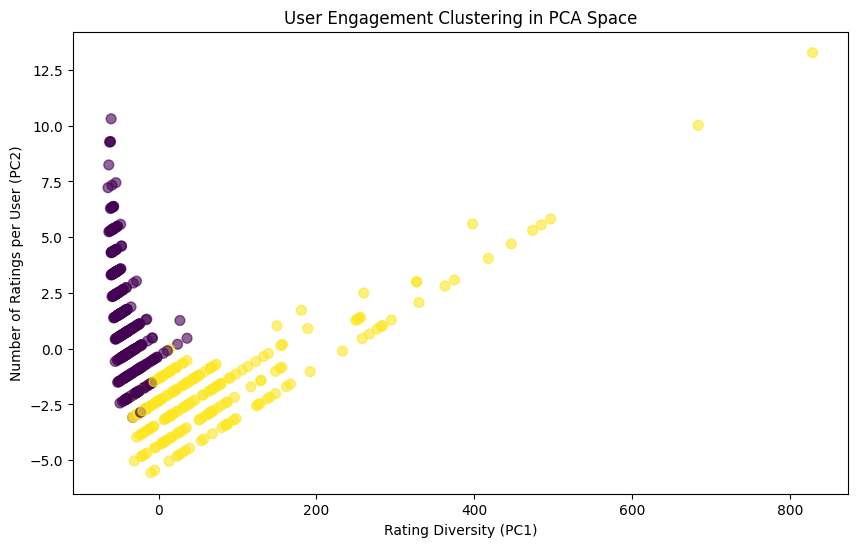

In [ ]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Perform PCA to reduce dimensionality to 2 components for easy plotting, excluding 'average_rating'
pca = PCA(n_components=2)
engagement_df_pca = pca.fit_transform(engagement_df[['rating_diversity', 'number_of_ratings_per_user']])

# Create a scatter plot of the clusters in the 2D PCA space
plt.figure(figsize=(10, 6))
scatter = plt.scatter(engagement_df_pca[:, 0], engagement_df_pca[:, 1], c=engagement_df['engagement_cluster'], cmap='viridis', s=50, alpha=0.6)

# Labels and title
plt.xlabel('Rating Diversity (PC1)')
plt.ylabel('Number of Ratings per User (PC2)')
plt.title('User Engagement Clustering in PCA Space')

# Show the plot
plt.show()



Cluster 0 (Lower Engagement Cluster):
- "Passive Engagers" or "Low-Engagement Users"

- These users tend to have lower rating_diversity and fewer number_of_ratings_per_user compared to the other cluster.

- This suggests they engage with the platform sporadically and may not interact with a wide variety of movies.

Cluster 1 (Higher Engagement Cluster):

- "Active Engagers" or "High-Engagement Users"

- These users have higher rating_diversity and a larger number of ratings per user.

- This indicates they are actively rating movies and exploring a wide range of options on the platform.



This dynamic hybrid model would:

Use CBF for high engagement users (Cluster 1), who are more likely to appreciate diverse and detailed content-based recommendations.

Use CF for low engagement users (Cluster 0), who may benefit from recommendations based on what similar users have liked.

In [ ]:
def recommend_hybrid(user_id, engagement_df, user_movie_matrix, df_ratings, item_similarity, user_similarity_df, df_movie_filtered):
    # Build mapping from movieId to index (and back)
    movie_ids = df_movie_filtered['id'].tolist()
    movie_id_to_index = {movie_id: idx for idx, movie_id in enumerate(movie_ids)}
    index_to_movie_id = {idx: movie_id for movie_id, idx in movie_id_to_index.items()}

    # Find user's engagement cluster
    engagement_cluster = engagement_df.loc[engagement_df['userId'] == user_id, 'engagement_cluster'].values[0]

    if engagement_cluster == 1:
        # High engagement → Collaborative Filtering
        print(f"Using CF for user {user_id}")

        similar_users = user_similarity_df[user_id].sort_values(ascending = False)[1:11]
        similar_users_indices = similar_users.index

        similar_users_ratings = user_movie_matrix.loc[similar_users_indices]

        predicted_ratings = similar_users_ratings.T.dot(similar_users) / similar_users.sum()

        user_rated_movies = user_movie_matrix.loc[user_id][user_movie_matrix.loc[user_id] > 0].index
        predicted_ratings = predicted_ratings.drop(user_rated_movies, errors = "ignore")
        top_movies = predicted_ratings.sort_values(ascending = False).head(10)

        probs = softmax(top_movies.values)

        return list(zip(top_movies.index.tolist(), probs))

    else:
        # Low engagement → Content-Based Filtering
        print(f"Using CBF for user {user_id}")

        # Use the highest rated movie to provide top-K recommendations
        user_ratings = df_ratings[df_ratings['userId'] == user_id]
        top_rated = user_ratings.sort_values(by='rating', ascending=False).iloc[0]
        movie_id = top_rated['movieId']

        # Check if the movie_id exists in the filtered movie list
        if movie_id not in movie_id_to_index:
            print(f"Warning: Movie ID {movie_id} not found in filtered movie list.")
            return []

        # Get index in similarity matrix
        movie_index = movie_id_to_index[movie_id]
        similarity_vector = item_similarity[movie_index]

        sim_scores = list(enumerate(similarity_vector))
        sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse = True)
        sim_scores = sim_scores[1:11]  # Skip the movie itself
        top_indices = [i[0] for i in sim_scores]
        probs = softmax([i[1] for i in sim_scores])

        top_movie_ids = [index_to_movie_id[idx] for idx in top_indices if idx in index_to_movie_id]
        return list(zip(top_movie_ids, probs))

# Ensure the filtered ratings only include valid movie IDs
valid_movie_ids = set(df_movies_metadata['id'])
df_ratings_filtered = df_ratings[df_ratings['movieId'].isin(valid_movie_ids)]

# Sample user_id for testing
user_id = 1

# Call the recommend_hybrid function
recommendations = recommend_hybrid(
    user_id,
    engagement_df,        # User engagement data
    user_movie_matrix,    # User-item matrix (ratings matrix)
    df_ratings_filtered,  # Ratings data
    similarity_matrix,    # Movie similarity matrix
    user_similarity_df,   # User similarity matrix
    df_movies_metadata     # Filtered movie information
)

# Output the recommended movies and their probabilities
for movie_id, prob in recommendations:
    print(f"Movie ID: {movie_id}, Probability: {prob:.4f}")

Using CBF for user 1
Movie ID: 26123, Probability: 0.1037
Movie ID: 51588, Probability: 0.1031
Movie ID: 42889, Probability: 0.1023
Movie ID: 14912, Probability: 0.1006
Movie ID: 94356, Probability: 0.1002
Movie ID: 27088, Probability: 0.0999
Movie ID: 23568, Probability: 0.0987
Movie ID: 8363, Probability: 0.0973
Movie ID: 15037, Probability: 0.0972
Movie ID: 253310, Probability: 0.0971


## Splitting of matrix to train and test sets

This is to ensure that when we perform evaluations for highly engaged users, we are predicting ratings for movies that the user has not rated.

In [ ]:
# Train-test split function
def train_test_split_user(user_movie_matrix, test_ratio=0.2):
    train_matrix = user_movie_matrix.copy()
    test_matrix = pd.DataFrame(0, index=user_movie_matrix.index, columns=user_movie_matrix.columns)

    for user_idx in range(user_movie_matrix.shape[0]):
        user_ratings = user_movie_matrix.iloc[user_idx]
        rated_items = user_ratings[user_ratings > 0].index
        n_test = int(len(rated_items) * test_ratio)

        if n_test > 0:
            test_items = np.random.choice(rated_items, size=n_test, replace=False)
            train_matrix.loc[user_movie_matrix.index[user_idx], test_items] = 0
            test_matrix.loc[user_movie_matrix.index[user_idx], test_items] = user_ratings[test_items]

    return train_matrix, test_matrix

train_matrix, test_matrix = train_test_split_user(user_movie_matrix)



C:\Users\User\AppData\Local\Temp\ipykernel_24344\2317532531.py:14: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '3.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  test_matrix.loc[user_movie_matrix.index[user_idx], test_items] = user_ratings[test_items]
C:\Users\User\AppData\Local\Temp\ipykernel_24344\2317532531.py:14: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '4.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  test_matrix.loc[user_movie_matrix.index[user_idx], test_items] = user_ratings[test_items]
C:\Users\User\AppData\Local\Temp\ipykernel_24344\2317532531.py:14: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '3.5' has dtype incompatible with int64, plea

In [ ]:
user_similarity_train = cosine_similarity(csr_matrix(train_matrix))
user_similarity_df_train = pd.DataFrame(user_similarity_train, index=train_matrix.index, columns=train_matrix.index)
predicted_ratings_user_train = user_similarity_df_train.dot(train_matrix) / np.abs(user_similarity_df_train).sum(axis=1).values.reshape(-1, 1)

## Evaluation of Hybrid Model

Evaluation is done based on the level of engagement of each user using K-value of 10 and the following metrics: Precision, Recall, NDCG and F1 Score.

For highly engaged users: Evaluate based on Collaborative Filtering. Ground truth is the movies that a user has already rated.

For less engaged users: Evaluate based on Content-Based Filtering. The ground truth will be movies that a user has rated before. For each movie similar to rated movies, we define the movie to be relevant if the similarity score exceeds a threshold of 60%.

In [ ]:
def cbf_dcg_at_k(r, k):
    r = np.asarray(r)[:k]
    if r.size:
        return np.sum(r / np.log2(np.arange(2, r.size + 2)))
    return 0.0

def cbf_ndcg_at_k(r, k):
    dcg_max = cbf_dcg_at_k(sorted(r, reverse=True), k)
    if not dcg_max:
        return 0.0
    return cbf_dcg_at_k(r, k) / dcg_max

def cf_dcg(relevance_scores, k):
    relevance_scores = np.asarray(relevance_scores)[:k]
    if relevance_scores.size:
        return np.sum(relevance_scores / np.log2(np.arange(2, relevance_scores.size + 2)))
    return 0.0

def cf_ndcg_k(true_relevance, predicted_scores, k=10):
    sorted_indices = np.argsort(predicted_scores)[::-1]
    sorted_true_relevance = true_relevance[sorted_indices]

    ideal_sorted_relevance = np.sort(true_relevance)[::-1]

    dcg_val = cf_dcg(sorted_true_relevance, k)
    idcg_val = cf_dcg(ideal_sorted_relevance, k)

    return dcg_val / idcg_val if idcg_val > 0 else 0

def cf_precision_at_k(true_relevance, predicted_scores, k=10):
    sorted_indices = np.argsort(predicted_scores)[::-1]
    sorted_true_relevance = true_relevance[sorted_indices]

    top_k_relevance = sorted_true_relevance[:k]

    relevant_count = np.sum(top_k_relevance > 0)

    if k > 0:
      return relevant_count / k
    return 0

def cf_recall_at_k(true_relevance, predicted_scores, k=10):
    sorted_indices = np.argsort(predicted_scores)[::-1]
    sorted_true_relevance = true_relevance[sorted_indices]

    top_k_relevance = sorted_true_relevance[:k]

    relevant_count = np.sum(top_k_relevance > 0)
    total_relevant = np.sum(true_relevance > 0)

    if total_relevant > 0:
      return relevant_count / total_relevant
    return 0

def evaluate_hybrid(K=10):
    movie_ids = df_movies_metadata['id'].tolist()
    movie_id_to_index = {movie_id: idx for idx, movie_id in enumerate(movie_ids)}
    index_to_movie_id = {idx: movie_id for movie_id, idx in movie_id_to_index.items()}

    precisions = []
    recalls = []
    ndcg_scores = []
    f1 = 0.0

    for user_id in range(user_movie_matrix.shape[0]):
        precision = 0.0
        recall = 0.0
        ndcg = 0.0

        # Get hybrid recommendations
        recs = recommend_hybrid(user_id + 1, engagement_df, train_matrix, df_ratings, similarity_matrix, user_similarity_df, df_movies_metadata)
        recommended_movies = [movie_id for movie_id, _ in recs]
        engagement = engagement_df.loc[engagement_df['userId'] == user_id + 1, 'engagement_cluster'].values[0]

        if engagement == 0:
          relevant = []

          user_rated_movies = user_movie_matrix.loc[user_id + 1][user_movie_matrix.loc[user_id + 1] > 0].index
          for movie_id in user_rated_movies:
            movie_index = movie_id_to_index[movie_id]
            all_similarities = similarity_df.loc[movie_index].drop(movie_index)
            relevant_indices = all_similarities[all_similarities >= 0.60].index
            for index in relevant_indices:
              movie = df_movies_metadata.loc[index]['id']
              if movie not in user_rated_movies:
                relevant.append(movie)

          hits = len(set(recommended_movies) & set(relevant))
          recall = hits / len(relevant) if len(relevant) > 0 else 0
          precision = hits / K

          ndcg_binary = [1 if id in relevant else 0 for id in recommended_movies]
          ndcg = cbf_ndcg_at_k(ndcg_binary, K)

        if engagement == 1:
          true_ratings = test_matrix.values[user_id]
          predicted = predicted_ratings_user_train.values[user_id]

          mask = true_ratings > 0

          if np.sum(mask) >= 2:  # Ensure there are at least 2 rated movies for the user
              precision = cf_precision_at_k(true_ratings[mask], predicted[mask], k=10)
              ndcg = cf_ndcg_k(true_ratings[mask], predicted[mask], k=10)
              recall = cf_recall_at_k(true_ratings[mask], predicted[mask], k=10)

        precisions.append(precision)
        recalls.append(recall)
        ndcg_scores.append(ndcg)

    hybrid_precision = np.mean(precisions)
    hybrid_recall = np.mean(recalls)
    hybrid_ndcg = np.mean(ndcg_scores)

    if hybrid_precision + hybrid_recall > 0:
      f1 = 2 * (hybrid_precision * hybrid_recall) / (hybrid_precision + hybrid_recall)

    hybrid_metrics = {
        'Precision': hybrid_precision,
        'Recall': hybrid_recall,
        'NDCG': hybrid_ndcg,
        'F1': f1
    }

    return hybrid_metrics

metrics = evaluate_hybrid(K=10)
print("Hybrid Model Evaluation Metrics:")
for metric, value in metrics.items():
    print(f"{metric}: {value:.4f}")

Using CBF for user 1
Using CF for user 2
Using CBF for user 3
Using CF for user 4
Using CF for user 5
Using CBF for user 6
Using CBF for user 7
Using CBF for user 8
Using CBF for user 9
Using CBF for user 10
Using CBF for user 11
Using CBF for user 12
Using CBF for user 13
Using CBF for user 14
Using CF for user 15
Using CBF for user 16
Using CF for user 17
Using CBF for user 18
Using CF for user 19
Using CBF for user 20
Using CF for user 21
Using CF for user 22
Using CF for user 23
Using CBF for user 24
Using CBF for user 25
Using CF for user 26
Using CBF for user 27
Using CBF for user 28
Using CBF for user 29
Using CF for user 30
Using CBF for user 31
Using CBF for user 32
Using CF for user 33
Using CF for user 34
Using CBF for user 35
Using CF for user 36
Using CBF for user 37
Using CBF for user 38
Using CBF for user 39
Using CBF for user 40
Using CF for user 41
Using CBF for user 42
Using CF for user 43
Using CBF for user 44
Using CBF for user 45
Using CBF for user 46
Using CBF for

From the metrics above, the model appears to be able to rank and recommend truly relevant movies as indicated by the high precision rate and NDCG score, however it is not good at identifying all relevant movies as shown by the lower recall rate. A possible explanation for this is the filter bubble problem - if a user has not been active in rating movies, the model will tend to provide recommendations that are too similar due to insufficient data of past interactions or movies rated, potentially stagnating user engagement over time. Only when a user has been very engaged in rating movies would he or she benefit from good quality recommendations from the hybrid model. Whilst the metrics obtained for this model would vary depending on the proportion of high engagement and low engagement users, it can be observed in this case that the drawbacks of Content-Based Filtering outweigh those of Collaborative Filtering, resulting in lower accuracy overall.